### Trade and Tariff Dataset at the County level

This notebook constructs a trade and county-level tariff data, over time, dataset. **This is a core notebook to the project** so I will try and explain each step clearly. This is one aspect of my code to be scrutinized. It outputs the county-level trade and tariff dataset as a `.parquet` file.

In [127]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

#import weightedcalcs as wc
#import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

from linearmodels.iv import IV2SLS
from linearmodels.panel import PanelOLS


In [128]:
fig_path = "C:\\github\\expenditure_tradeshocks\\figures"

### Step 1 Grab and manipulate the county level data for 2017

So we will grab the single file, then adjust it to suit our needs. The needs are to construct county-level employment weights to create a trade exposure metric and tariff metric for each county.

In [129]:
url = "https://data.bls.gov/cew/data/files/2017/csv/2017_annual_singlefile.zip"
# This will read in the annual, single file. It's big, but has all we want...

r = requests.get(url) 

# convert bytes to zip file  
bls_sf = zf.ZipFile(io.BytesIO(r.content)) 
print('Type of zipfile object:', type(bls_sf))

clist = ['area_fips', 'own_code', 'industry_code', 'agglvl_code', 'size_code',
       'year', 'disclosure_code', 'annual_avg_estabs',
       'annual_avg_emplvl', 'total_annual_wages','avg_annual_pay']

df = pd.read_csv(bls_sf.open(bls_sf.namelist()[0]), usecols= clist)

# SHOULD PRESPECIFY TYPES TO 

df.head()


Type of zipfile object: <class 'zipfile.ZipFile'>


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay
0,1000,0,10,50,0,2017,NaN,124881,1936819,89088710816,45997
1,1000,1,10,51,0,2017,NaN,1208,53131,4339038631,81668
2,1000,1,102,52,0,2017,NaN,1208,53131,4339038631,81668
3,1000,1,1021,53,0,2017,NaN,610,11173,716001109,64083
4,1000,1,1022,53,0,2017,NaN,2,12,369309,30354


Then the file below cleans stuff up. The most important is the `NAICS_county_level` which selects the NAICS aggregation and then the county aggregation. Website describing this is here:

[https://data.bls.gov/cew/doc/titles/agglevel/agglevel_titles.htm](https://data.bls.gov/cew/doc/titles/agglevel/agglevel_titles.htm)

In [130]:
NAICS_county_level = 75 
# This is the code that will select only counties at the 3 digit NAICS level

df_county = df[df.agglvl_code == NAICS_county_level].copy()

df_county = df_county[df_county.own_code == 5]
# Only grab private stuff

df_county = df_county[(df_county.area_fips.str[0:2] != "72") & (df_county.area_fips.str[0:2] != "78")
              & (df_county.area_fips.str[0:2] != "02") & (df_county.area_fips.str[0:2] != "15")]
#Drop puerto rico, alaska, hawaii...this mayb not be doing what I think it is...as it looks like these guys are there
# Does not matter as analysis is performed withthem, drop them when do the map. 

df_county["sup_ind"] = df_county.industry_code.str[1].astype(int)
# sometimes there are super industries floating around we want to drop them.
# not clear if this matters with the conditioning all ready

df_county = df_county[df_county["sup_ind"] > 0]

df_county.area_fips = df_county.area_fips.astype(str)

df_national = df_county.groupby("industry_code").agg({"annual_avg_emplvl": "sum"})

In [131]:
df_national.reset_index(inplace = True)

In [132]:
df_national.rename({"annual_avg_emplvl":"nat_emplvl"}, axis = 1, inplace = True)

In [133]:
df_national.head()

,industry_code,nat_emplvl
0,111,534697
1,112,228471
2,113,45166
3,114,5005
4,115,352957


Let's compute annual employment. 

In [134]:
df_county.annual_avg_emplvl.sum()

115756851

which matches well with FRED (https://fred.stlouisfed.org/series/USPRIV) in 2017 (off by a couple million)

---
### Step 2 Bring in the trade data

Here we will read in data at the HS6 level, exports to china, over time. 

In [136]:
my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"
# This is my key. I'm nice and I have it posted. If you will be doing more with this
# please get your own key!

end_use = "hs?get=E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME"

url = "https://api.census.gov/data/timeseries/intltrade/exports/" + end_use 
url = url + my_key + "&time==from+2016-01" + "&COMM_LVL=HS6"

url = url + "&CTY_CODE=5700"

r = requests.get(url) 

df_china_trade = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

df_china_trade.columns = r.json()[0]

df_china_trade.time = pd.to_datetime(df_china_trade.time, format="%Y-%m")
# This is so I can call this correctly...

df_china_trade["china_trade"] = df_china_trade.ALL_VAL_MO.astype(float)

df_china_trade.E_COMMODITY = df_china_trade.E_COMMODITY.astype(str)

df_china_trade.tail(10)

,E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME,time,COMM_LVL,CTY_CODE,china_trade
170841,970200,5700,61873,CHINA,2019-09-01,HS6,5700,61873.0
170842,970300,5700,4385571,CHINA,2019-09-01,HS6,5700,4385571.0
170843,970500,5700,6470,CHINA,2019-09-01,HS6,5700,6470.0
170844,970600,5700,3727916,CHINA,2019-09-01,HS6,5700,3727916.0
170845,980110,5700,46614707,CHINA,2019-09-01,HS6,5700,46614707.0
170846,980210,5700,70400,CHINA,2019-09-01,HS6,5700,70400.0
170847,980220,5700,6601,CHINA,2019-09-01,HS6,5700,6601.0
170848,980230,5700,0,CHINA,2019-09-01,HS6,5700,0.0
170849,980240,5700,71450,CHINA,2019-09-01,HS6,5700,71450.0
170850,988000,5700,48452349,CHINA,2019-09-01,HS6,5700,48452349.0


Now grab **total exports** (not just China) by HS6 level, overtime. 

In [137]:
r

<Response [200]>

In [138]:
end_use = "hs?get=E_COMMODITY,ALL_VAL_MO"

url = "https://api.census.gov/data/timeseries/intltrade/exports/"
url = url + end_use + my_key + "&time==from+2016-01" + "&COMM_LVL=HS6"

r = requests.get(url) 

df_all_trade = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

df_all_trade.columns = r.json()[0]

df_all_trade.time = pd.to_datetime(df_all_trade.time, format="%Y-%m")
# This is so I can call this correctly...

df_all_trade["total_trade"] = df_all_trade.ALL_VAL_MO.astype(float)

df_all_trade.E_COMMODITY = df_all_trade.E_COMMODITY.astype(str)

df_all_trade.head(10)

,E_COMMODITY,ALL_VAL_MO,time,COMM_LVL,total_trade
0,251910,8056,2018-06-01,HS6,8056.0
1,340590,26610794,2018-03-01,HS6,26610794.0
2,843680,20379462,2016-02-01,HS6,20379462.0
3,251910,179927,2018-08-01,HS6,179927.0
4,271600,40580793,2018-08-01,HS6,40580793.0
5,340590,26429239,2018-08-01,HS6,26429239.0
6,251910,23023,2019-01-01,HS6,23023.0
7,271600,42102672,2019-01-01,HS6,42102672.0
8,340590,21225462,2019-01-01,HS6,21225462.0
9,843680,32462047,2018-04-01,HS6,32462047.0


Then combine the china trade and the all trade dataset.

In [139]:
dftrade = df_all_trade.merge(df_china_trade[["E_COMMODITY", "time","china_trade"]], left_on = ["E_COMMODITY", "time"], 
                             right_on = ["E_COMMODITY", "time"], how = "left")

dftrade.set_index("time", inplace = True)

dftrade.drop(["ALL_VAL_MO"], axis = 1, inplace = True)

---
### Step 3 Bring in concordance, create annual and national data set.

Assign Naics codes, create a annual 2017 `df`, create the trade wieghts by naics so we can aggregate the tariffs.

In [140]:
dftrade_17 = dftrade.loc["2017"].groupby("E_COMMODITY").agg({"china_trade":"sum"})

Use the concordance from the US Census to go from HS6 to NAICS. In the code below there are two different approaches to working with the concordance. The latter one makes more sense. Ultimatly does not matter. 

In [141]:
#url = "https://www.census.gov/foreign-trade/reference/codes/concordance/expconcord17.xls"

#df_concordance = pd.read_excel(url, dtype = {"commodity": str, "naics": str})

#df_concordance["hs8"] = df_concordance.commodity.str[0:8]
# truncate down to get the hs8

#df_concordance["hs6"] = df_concordance.commodity.str[0:6]
# truncate down to get the hs6

#df_concordance["naics3"] = df_concordance["naics"].str[0:3]

#dict_concordance = dict(zip(df_concordance.hs6,df_concordance.naics)) 

# This creates a dictionaty from which we can map the hs6 to the naics codes

# Full disclosure. There is an issue with the creation of the dictionary as a unique 
# mapping from hs6 to naics. The notebook ``alt_hs_naics_mapping.ipynb'' provides a complete discussion.
# Ultimatly, this does not matter for the results (relative to the alternative below)

# Below is a fix/alternative approach to creating the mapping from hs6 to naics. In the
# cases where there are multiple naics codes for each hs6 code, it assigns the naics code that is
# associated with the most trade. 

# For future reference check this out: https://www.bea.gov/industry/zip/NDN0317.zip

file_path = os.getcwd()

alt_concordance = pq.read_table(file_path + "\\data\\alt_concordance.parquet").to_pandas()

alt_concordance.head()

dict_concordance = dict(zip(alt_concordance.hs6,alt_concordance.naics)) 

Then create this at different levels

In [142]:
dftrade_17["hs6"] = dftrade_17.index

dftrade_17["naics"] = dftrade_17["hs6"].map(dict_concordance)

dftrade_17["naics4"] = dftrade_17["naics"].str[0:4]

dftrade_17["naics3"] = dftrade_17["naics"].str[0:3]

dftrade_17.rename({"china_trade":"2017_china_trade"}, axis = 1, inplace = True)

In [143]:
dftrade_17.head()

,2017_china_trade,hs6,naics,naics4,naics3
E_COMMODITY,,,,,
010121,29098.0,010121,112920,1129,112
010129,27975.0,010129,112920,1129,112
010130,8340.0,010130,112920,1129,112
010190,0.0,010190,112920,1129,112
010221,80280.0,010221,11211X,1121,112


This look good, we have the commodity (as the index), chinese trade, and then different codes to map stuff to. 

Here we will work at the NAICS 3 digit level. The rational for this is that if you go more disaggregate, then confidentialy issues lead to employment at the county-level to be drpoed from the QECW. This is just a simple ``.groupby`` operation. 

In [144]:
dftrade_17_naics3 = dftrade_17.groupby("naics3").agg({"2017_china_trade": "sum"})

In [145]:
dftrade_17_naics3.head()

,2017_china_trade
naics3,
111,1.578543e+10
112,1.066820e+08
113,1.316022e+09
114,1.322142e+09
211,6.731515e+09


Now merge this with the national employment by naics data set.

In [146]:
df_national = df_national.merge(dftrade_17_naics3["2017_china_trade"],
                                left_on = "industry_code", right_index = True, how = "left")

In [147]:
df_national["2017_china_trade"].replace(np.nan, 0, inplace = True)

df_national["trd_wts"] = (df_national["2017_china_trade"]/df_national["2017_china_trade"].sum())

Then check to make sure that the trade weights sum up to one.

In [148]:
df_national.trd_wts.sum()

1.0

In [149]:
dftrade["hs6"] = dftrade.E_COMMODITY

dftrade["naics"] = dftrade["hs6"].map(dict_concordance)

dftrade["naics4"] = dftrade["naics"].str[0:4]

dftrade["naics3"] = dftrade["naics"].str[0:3]

---
### Step 4 Add in the tariff data...

Now here is one of the harder parts.

We want to take the time series data, then layer on the tariff data by product and time. So we will have a big data frame that is (at HS6 level) over time, but each unit of observation has the associated 2017 annual value and the tariff at that date. 

So we will use the `map` function to exploit this.

In [150]:
#tariffs = pd.read_csv("tariff_list_naics.csv", dtype = {"HS-8 code": str,"HS6": str,"naics": str,"naics4": str})

file_path = os.getcwd() + "\\data"

# bring in the tariff data

tariffs = pd.read_csv(file_path + "\\new_tariff_list_max.csv", dtype = {"hs6": str})
# This is the tariff dataset created by updated_tariff_data.ipynb (note the max tariff means taking the largest value
# when going from Chinese hs10 to hs6. This does not matter, if anything gives more conservative resutls)

tariffs.time_of_tariff = pd.to_datetime(tariffs.time_of_tariff, format="%Y-%m")
# make sure the time is there.

tariffs.set_index("time_of_tariff",inplace = True)

In [151]:
tariffs.head()

,hs6,tariff
time_of_tariff,,
2018-01-01,010121,0.0
2018-04-02,010121,0.0
2018-05-01,010121,0.0
2018-07-01,010121,0.0
2018-07-06,010121,0.0


Then we create dictionaries to do the following " you tell me HS, I tell you tariff" by time. 

In [152]:
initial_tariff = dict(zip(tariffs.loc["2018-01-01"].hs6,tariffs.loc["2018-01-01"].tariff)) 
# These are the initial mfn tariffs. We will apply these from 2017 up untill the changes...

tariff_dict_232 = dict(zip(tariffs.loc["2018-04-02"].hs6,tariffs.loc["2018-04-02"].tariff)) 
#These are the section 232 tariffs, response to US steel and aluminum. 

tariff_dict_r1 = dict(zip(tariffs.loc["2018-07-06"].hs6,tariffs.loc["2018-07-06"].tariff)) 
#tariff_dict_r1 = dict(zip(tariffs.loc["2018-07-06"].HS6,tariffs.loc["2018-07-06"].tariff)) 
# This will create a mapping from HS6 to tariff, you tell me HS, I tell you tariff

tariff_dict_r2 = dict(zip(tariffs.loc[dt.datetime(2018,8,23)].hs6,tariffs.loc[dt.datetime(2018,8,23)].tariff)) 

#tariff_dict_r2 = dict(zip(tariffs.loc[dt.datetime(2018,8,23)].HS6,tariffs.loc[dt.datetime(2018,8,23)].tariff)) 
# This will create a mapping from HS6 to tariff, you tell me HS, I tell you tariff, round 2

tariff_dict_r3 = dict(zip(tariffs.loc[dt.datetime(2018,9,24)].hs6,tariffs.loc[dt.datetime(2018,9,24)].tariff))
#tariff_dict_r3 = dict(zip(tariffs.loc[dt.datetime(2018,9,24)].HS6,tariffs.loc[dt.datetime(2018,9,24)].tariff)) 
# This will create a mapping from HS6 to tariff, you tell me HS, I tell you tariff, round 3

tariff_dict_mfn = dict(zip(tariffs.loc["2018-11-01"].hs6,tariffs.loc["2018-11-01"].tariff))
# This reflects mfn adjustments that China made later in the year.

tariff_dict_mfn_2019 = dict(zip(tariffs.loc["2019-01-02"].hs6,tariffs.loc["2019-01-02"].tariff))
# This reflects mfn adjustments and auto adjustment China made at the start of 2019

Then assign the tariffs to the hs6 codes. As mentioned below, the ``.update`` function updates the product code with a new tariff if there is one in the new dictionary.

In [153]:
dftrade["tariff"] = 0

# Then use the map function which will fill in the tariff in the correct places..
# Note the key issue was that the dictionaries were overwritting stuff, hence
# the update...

# Start with the MFN...
dftrade.loc["2015-01":,"tariff"] = dftrade.loc["2015-01":,"hs6"].map(initial_tariff)

#print("done")
# Now update given the 232 response
initial_tariff.update(tariff_dict_232)

dftrade.loc["2018-04":,"tariff"] = dftrade.loc["2018-04":,"hs6"].map(initial_tariff)

#print("done")
# This is the big Phase 1 of the war
initial_tariff.update(tariff_dict_r1)

dftrade.loc["2018-07":,"tariff"] = dftrade.loc["2018-07":,"hs6"].map(initial_tariff)

#print("done")
# Here is phase 2
initial_tariff.update(tariff_dict_r2)

dftrade.loc["2018-09":,"tariff"] = dftrade.loc["2018-09":,"hs6"].map(initial_tariff)

#print("done")
# Here is phase 3
initial_tariff.update(tariff_dict_r3)

dftrade.loc["2018-10":,"tariff"] = dftrade.loc["2018-10":,"hs6"].map(initial_tariff)

#print("done")
# China then adjusts the mfn
initial_tariff.update(tariff_dict_mfn)

dftrade.loc["2018-11":,"tariff"] = dftrade.loc["2018-11":,"hs6"].map(initial_tariff)

#print("done")
# An update on the mfn's
initial_tariff.update(tariff_dict_mfn_2019)

dftrade.loc["2019-01":,"tariff"] = dftrade.loc["2019-01":,"hs6"].map(initial_tariff)

dftrade["tariff"] = dftrade["tariff"].replace(np.nan,0)

dftrade[dftrade["tariff"] == 25].head()

dftrade["2018-08"].head(25)

,E_COMMODITY,COMM_LVL,total_trade,china_trade,hs6,naics,naics4,naics3,tariff
time,,,,,,,,,
2018-08-01,251910,HS6,179927.0,0.0,251910,212325,2123,212,1.0
2018-08-01,271600,HS6,40580793.0,NaN,271600,990000,9900,990,0.0
2018-08-01,340590,HS6,26429239.0,3880116.0,340590,325612,3256,325,6.5
2018-08-01,843680,HS6,33992614.0,1090782.0,843680,333120,3331,333,10.0
2018-08-01,282732,HS6,2450529.0,125200.0,282732,325180,3251,325,5.5
2018-08-01,440310,HS6,5999758.0,1727927.0,440310,321114,3211,321,0.0
2018-08-01,590691,HS6,1653878.0,5778.0,590691,313320,3133,313,10.0
2018-08-01,750711,HS6,129109.0,0.0,750711,331491,3314,331,6.0
2018-08-01,730840,HS6,9026542.0,26464.0,730840,332323,3323,332,8.4


This is looking good, not how you can see the tariffs (in august of 2018) hitting in the right places.

Now merge it with the 2017 annual trade data so we can construct trade weighted averages of tariffs....

In [154]:
dftrade = dftrade.merge(dftrade_17["2017_china_trade"], how = "inner", left_on = "E_COMMODITY", right_index = True)

In [155]:
dftrade[dftrade.naics3 == "111"].sort_values(by = ["tariff"], ascending = False)

,E_COMMODITY,COMM_LVL,total_trade,china_trade,hs6,naics,naics4,naics3,tariff,2017_china_trade
time,,,,,,,,,,
2019-06-01,100119,HS6,13245538.0,NaN,100119,111140,1111,111,90.0,0.0
2019-08-01,100199,HS6,568427174.0,0.0,100199,111140,1111,111,90.0,351092196.0
2019-05-01,100119,HS6,25314226.0,NaN,100119,111140,1111,111,90.0,0.0
2018-09-01,100119,HS6,15378454.0,NaN,100119,111140,1111,111,90.0,0.0
2019-01-01,100199,HS6,492250699.0,NaN,100199,111140,1111,111,90.0,351092196.0
...,...,...,...,...,...,...,...,...,...,...
2018-07-01,120721,HS6,66944.0,NaN,120721,111920,1119,111,0.0,0.0
2017-01-01,120721,HS6,269541.0,NaN,120721,111920,1119,111,0.0,0.0
2018-12-01,120721,HS6,1163412.0,NaN,120721,111920,1119,111,0.0,0.0


Looks like we accomplished this task.

Now what we will do is create a function which will make the trade weighted verage of the tariff rates as we aggregate across product codes.

In [156]:
def trd_weighted_avg(df):
    # A function to create the trade weighted average of the tariff rates
    # by round...
    
    trd_w_avg = df["tariff"].multiply(df["2017_china_trade"],axis = 0).sum() 
    # here wuse the 2017 annual values to weight it
    
    trd_w_avg = trd_w_avg / df["2017_china_trade"].sum()
    
    
    foo = {"tariff_trd_w_avg": [trd_w_avg ], 
           "total_trade": df["total_trade"].sum(),
          "china_trade" : df["china_trade"].sum()}
    
    return pd.DataFrame(foo)

Now, `groupby` time and NAICS code (in this case 3), apply the trade weighted function above. Then the resulting data frame should be time, and naics tariffs and the total trade. 

In [157]:
grp = dftrade.groupby(["time","naics3"])

exp_trf_bynaics = grp.apply(trd_weighted_avg)

exp_trf_bynaics = exp_trf_bynaics.droplevel(2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [158]:
exp_trf_bynaics.loc["2018-01"].head(15)

tariff_trd_w_avg   total_trade   china_trade
time       naics3                                              
2018-01-01 111             7.738951  6.044481e+09  1.580785e+09
           112            11.923402  1.404933e+08  1.722368e+06
           113             0.185764  2.036270e+08  8.089366e+07
           114             8.826240  2.423345e+08  5.709779e+07
           211             0.656623  4.646889e+09  9.177222e+08
           212             1.669023  1.505520e+09  1.383602e+08
           311            11.732877  5.094319e+09  2.287681e+08
           312            10.654408  6.084754e+08  8.101847e+06
           313             9.065944  7.326278e+08  2.913878e+07
           314             9.958472  2.601312e+08  4.274722e+06
           315            15.546809  4.048624e+08  7.298691e+06
           316             9.889121  2.988748e+08  3.691118e+07
           321             0.180372  5.539431e+08  1.309546e+08
           322             2.215004  2.021641e+09  2.241574e+08
           323             3.078089  4.107334e+08  1.171687e+07

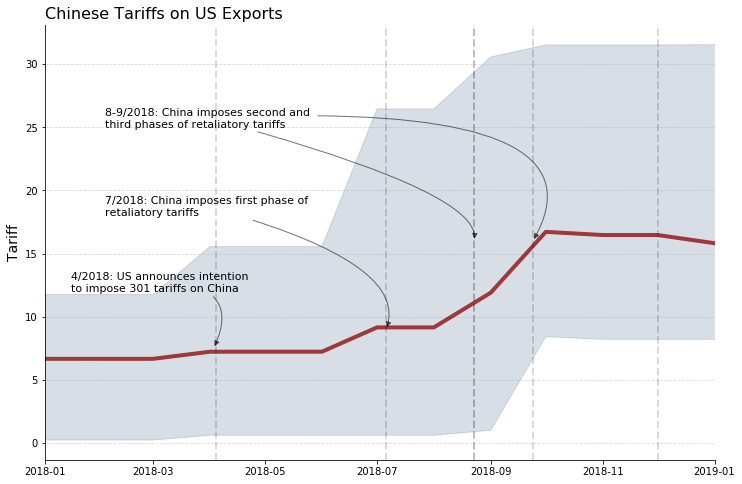

In [159]:
fig, ax = plt.subplots(figsize = (12,8))

mike_blue = tuple(np.array([20, 64, 134]) / 255)

tariffs_over_time = exp_trf_bynaics.groupby(["time"]).agg({"tariff_trd_w_avg": "mean"})

tariff_upqant = exp_trf_bynaics.groupby(["time"]).tariff_trd_w_avg.quantile(0.90)

tariff_lwqant = exp_trf_bynaics.groupby(["time"]).tariff_trd_w_avg.quantile(0.10)

ax.plot(tariffs_over_time, alpha = 0.75, color = 'darkred', linewidth = 4)

ax.fill_between(tariffs_over_time.index, tariff_lwqant, tariff_upqant, color = "#3F5D7D", alpha = 0.2)

#ax.plot(tariff_upqant, alpha = 0.95, color = mike_blue, linewidth = 4)

#ax.plot(tariff_lwqant, alpha = 0.95, color = mike_blue, linewidth = 4)

#ax.plot(auto_least, alpha = 0.95, color = mike_blue, linewidth = 4, 
#        label = 'Difference between top and bottom\nquartile of county level Chinese tariff exposure')

#ax.plot(, alpha = 0.95, color = mike_blue , linewidth = 4, 
#        label = 'Bottom Quantile of Chinese Tariff Exposure Counties')

ax.set_xlim(dt.datetime(2018,1,1),dt.datetime(2019,1,1))

ax.spines["right"].set_visible(False)

ax.spines["top"].set_visible(False)

ax.yaxis.grid(alpha= 0.5, linestyle= "--")

label_descrip = "Tariff"

ax.set_ylabel(label_descrip, fontsize = 14)

ax.axvline(dt.datetime(2018,4,4), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,7,6), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,8,23), linewidth = 2, ls = "--", color = 'k', alpha =0.25)

ax.axvline(dt.datetime(2018,9,24), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,12,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.set_title("Chinese Tariffs on US Exports", fontsize = 16, loc= "left" )

##############################################################################################

ax.annotate(
    "4/2018: US announces intention\nto impose 301 tariffs on China", 
    xy=(dt.datetime(2018,4,3), 7.5), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,1,15), 12), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=0,angleB=65",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

##############################################################################################

ax.annotate(
    "7/2018: China imposes first phase of\nretaliatory tariffs", 
    xy=(dt.datetime(2018,7,6), 9), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,2,3), 18), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=70",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8-9/2018: China imposes second and \nthird phases of retaliatory tariffs", 
    xy=(dt.datetime(2018,8,23), 16), color='white',# This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,2,3), 25), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=80",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8-9/2018: China imposes second and \nthird phases of retaliatory tariffs", 
    xy=(dt.datetime(2018,9,24), 16), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,2,3), 25), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=3,angleB=60",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

##############################################################################################


##############################################################################################
fig_path = "C:\\github\\measuring_trade_elasticities\\figures"
plt.savefig(fig_path + "\\tariffs_time.pdf", bbox_inches = "tight", dip = 3600)

#plt.savefig("simple_county_by_quantile.png", bbox_inches = "tight", dip = 3600)

plt.show()

In [160]:
tariff_lwqant

time
2016-01-01    0.230296
2016-02-01    0.230296
2016-03-01    0.230296
2016-04-01    0.230296
2016-05-01    0.230296
2016-06-01    0.230296
2016-07-01    0.230296
2016-08-01    0.230296
2016-09-01    0.230296
2016-10-01    0.230296
2016-11-01    0.230296
2016-12-01    0.230303
2017-01-01    0.231026
2017-02-01    0.231029
2017-03-01    0.231029
2017-04-01    0.231029
2017-05-01    0.231029
2017-06-01    0.231029
2017-07-01    0.231029
2017-08-01    0.231029
2017-09-01    0.231029
2017-10-01    0.231029
2017-11-01    0.231029
2017-12-01    0.231029
2018-01-01    0.231022
2018-02-01    0.231022
2018-03-01    0.231022
2018-04-01    0.609537
2018-05-01    0.609537
2018-06-01    0.609537
2018-07-01    0.609537
2018-08-01    0.609537
2018-09-01    1.001765
2018-10-01    8.414854
2018-11-01    8.207095
2018-12-01    8.207095
2019-01-01    8.207095
2019-02-01    8.207095
2019-03-01    8.207095
2019-04-01    8.207095
2019-05-01    8.207095
2019-06-01    8.207095
2019-07-01    8.207095
2019-0

This simple plot looks a lot like the Bowen figures. Note that the dip is all about China changing their MFN tariffs in (what appears to be) certain consumer orinted catagories as Bowen point out. So clothing stuff falls, while they are hammering the ag. products. 

Looks like we accomplished this task. Just a couple of things to clean up then we are ready to move onto the next step. 

In [161]:
exp_trf_bynaics["time"] = exp_trf_bynaics.index.get_level_values(0)

In [162]:
exp_trf_bynaics = exp_trf_bynaics.droplevel(level=0)

In [163]:
exp_trf_bynaics.reset_index(inplace = True)

In [164]:
exp_trf_bynaics.set_index(["naics3","time"], inplace = True)

In [165]:
exp_trf_bynaics.head()

,,tariff_trd_w_avg,total_trade,china_trade
naics3,time,,,
111,2016-01-01,7.738919,5.275188e+09,1.613464e+09
112,2016-01-01,11.923585,1.474526e+08,5.060756e+06
113,2016-01-01,0.173604,1.693344e+08,4.530732e+07
114,2016-01-01,8.220618,1.990871e+08,2.359890e+07
211,2016-01-01,0.656623,1.427629e+09,1.031669e+08


In [166]:
exp_trf_bynaics["log_tariff"] = np.log(1+.01*exp_trf_bynaics["tariff_trd_w_avg"])

exp_trf_bynaics["log_exp_total"] = np.log(exp_trf_bynaics["total_trade"]).replace(-np.inf, np.nan)

exp_trf_bynaics["log_exp_china"] = np.log(exp_trf_bynaics["china_trade"]).replace(-np.inf, np.nan)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [175]:
exp_trf_bynaics["log_tariff_change"] = exp_trf_bynaics.groupby(["naics3"]).log_tariff.diff(12)

exp_trf_bynaics.sort_values(["naics3", "time"], inplace = True)

exp_trf_bynaics["china_growth"] = exp_trf_bynaics.groupby(["naics3"]).log_exp_china.diff(12)

exp_trf_bynaics.sort_values(["naics3", "time"], inplace = True)

exp_trf_bynaics["all_growth"] = exp_trf_bynaics.groupby(["naics3"]).log_exp_total.diff(12)

exp_trf_bynaics.sort_values(["naics3", "time"], inplace = True)

In [176]:
exp_trf_bynaics["const"] = 1

In [177]:
trans = lambda df: df.iloc[0:11].mean()

#trade_county.groupby(["GEOFIPS"]).log_tariff.transform(trans)

exp_trf_bynaics["avg_trade"] = exp_trf_bynaics.groupby(["naics3"]).china_trade.transform(trans)

In [179]:
idx = pd.IndexSlice

all_vars = ["const", "log_tariff_change", 'china_growth',"avg_trade"]

dataset = exp_trf_bynaics[all_vars].loc[idx[:,"2017-01-01":"2019-06-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset["avg_trade"].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

mod = PanelOLS(dataset.china_growth, dataset[exog_vars], weights = weights, time_effects = True
              )

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(fe_res)

dfr = pd.concat([dataset.china_growth, fe_res.fitted_values],1).dropna()
print(dfr.corr().iloc[0,1] ** 2)

30
31
                          PanelOLS Estimation Summary                           
Dep. Variable:           china_growth   R-squared:                        0.1792
Estimator:                   PanelOLS   R-squared (Between):              0.6479
No. Observations:                 900   R-squared (Within):               0.2161
Date:                Tue, Dec 03 2019   R-squared (Overall):              0.2771
Time:                        09:37:57   Log-likelihood                   -536.73
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      204.52
Entities:                          30   P-value                           0.0000
Avg Obs:                       30.000   Distribution:                   F(1,869)
Min Obs:                       30.000                                           
Max Obs:                       30.000   F-statistic (robust):             9.7030
                      

In [172]:
idx = pd.IndexSlice

all_vars = ["const", "log_tariff_change", 'china_growth',"avg_trade"]

dataset = exp_trf_bynaics[all_vars].loc[idx[:,"2017-01-01":"2019-06-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset["avg_trade"].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

mod = PanelOLS(dataset.china_growth, dataset[exog_vars], weights = weights, time_effects = True,
               entity_effects=True)

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(fe_res)

dfr = pd.concat([dataset.china_growth, fe_res.fitted_values],1).dropna()
print(dfr.corr().iloc[0,1] ** 2)

30
31
                          PanelOLS Estimation Summary                           
Dep. Variable:           china_growth   R-squared:                        0.0881
Estimator:                   PanelOLS   R-squared (Between):              0.5692
No. Observations:                 900   R-squared (Within):               0.2034
Date:                Tue, Dec 03 2019   R-squared (Overall):              0.2551
Time:                        09:34:49   Log-likelihood                   -498.99
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      90.829
Entities:                          30   P-value                           0.0000
Avg Obs:                       30.000   Distribution:                   F(1,840)
Min Obs:                       30.000                                           
Max Obs:                       30.000   F-statistic (robust):             6.1587
                      

In [ ]:
dfr = pd.concat([dataset.china_growth, fe_res.fitted_values],1).dropna()
print(dfr.corr().iloc[0,1] ** 2)

In [180]:
file_path = "C:\\github\\measuring_trade_elasticities\\data\\trade_elasticity.parquet"

pq.write_table(pa.Table.from_pandas(dftrade.reset_index()), file_path)